11161
11041
Accuracy (wide): 0.76
Accuracy (wide): 0.90
Accuracy (wide): 0.79
Accuracy (wide): 0.72
Accuracy (wide): 0.79
Accuracy (deep): 0.79
Accuracy (deep): 0.79
Accuracy (deep): 0.90
Accuracy (deep): 0.86
Accuracy (deep): 0.79
Wide: 79.31% (+/- 5.77%)
Deep: 82.76% (+/- 4.36%)
Retrain a deep model
Final model accuracy: 80.95%
[3.600e-03 7.800e-03 9.200e-03 3.870e-02 5.300e-02 1.197e-01 1.243e-01
 1.026e-01 1.239e-01 8.880e-02 9.370e-02 1.245e-01 1.599e-01 1.542e-01
 1.846e-01 1.732e-01 1.477e-01 1.748e-01 1.455e-01 1.579e-01 2.257e-01
 1.975e-01 3.368e-01 5.828e-01 8.505e-01 1.000e+00 8.457e-01 6.624e-01
 5.564e-01 3.925e-01 3.233e-01 2.054e-01 1.920e-01 2.227e-01 3.147e-01
 2.268e-01 7.950e-02 7.480e-02 1.166e-01 1.969e-01 2.619e-01 2.507e-01
 1.983e-01 9.480e-02 9.310e-02 9.650e-02 3.810e-02 4.350e-02 3.360e-02
 5.500e-03 7.900e-03 1.190e-02 5.500e-03 3.500e-03 3.600e-03 4.000e-04
 1.800e-03 4.900e-03 2.400e-03 1.600e-03] -> [0.9173403] (expected [1.])
[0.0249 0.0119 0.0277 0.076

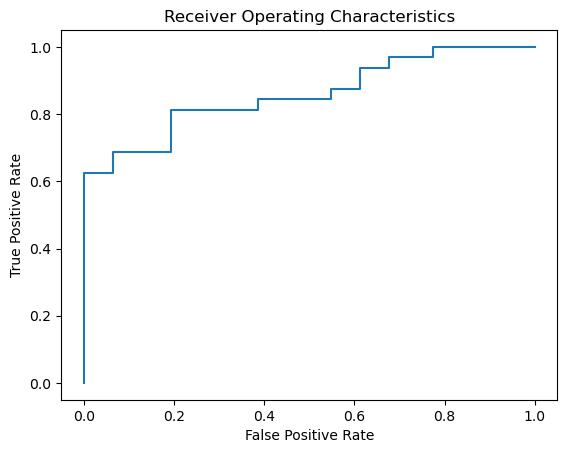

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

# Read data
data = pd.read_csv("dataset/sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

# Binary encoding of labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()